In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime

from matplotlib import pyplot as plt
from matplotlib import image as img
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import plot_lifetimes

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from lifelines.statistics import multivariate_logrank_test

plt.rcParams.update({"xtick.labelsize": 6,
                     "ytick.labelsize": 6,
                    })

In [2]:
df = pd.read_csv('./heart_failure_clinical_records_dataset.csv', sep=',')

In [3]:
df_train, df_test = train_test_split(df, test_size=0.33, shuffle=True, random_state=100)
df_test = df_test.set_index(np.arange(len(df_test)))

In [4]:
df_train.shape

(200, 13)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 191 to 8
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       200 non-null    float64
 1   anaemia                   200 non-null    int64  
 2   creatinine_phosphokinase  200 non-null    int64  
 3   diabetes                  200 non-null    int64  
 4   ejection_fraction         200 non-null    int64  
 5   high_blood_pressure       200 non-null    int64  
 6   platelets                 200 non-null    float64
 7   serum_creatinine          200 non-null    float64
 8   serum_sodium              200 non-null    int64  
 9   sex                       200 non-null    int64  
 10  smoking                   200 non-null    int64  
 11  time                      200 non-null    int64  
 12  DEATH_EVENT               200 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 21.9 KB


In [6]:
df_train.sample(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
207,85.0,0,212,0,38,0,186000.0,0.9,136,1,0,187,0
17,45.0,0,582,0,14,0,166000.0,0.8,127,1,0,14,1
5,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8,1
54,60.0,1,260,1,38,0,255000.0,2.2,132,0,1,45,1
241,65.0,0,582,1,30,0,249000.0,1.3,136,1,1,212,0
87,65.0,1,68,1,60,1,304000.0,0.8,140,1,0,79,0
12,45.0,1,981,0,30,0,136000.0,1.1,137,1,0,11,1
67,72.0,1,110,0,25,0,274000.0,1.0,140,1,1,65,1
36,90.0,1,60,1,50,0,226000.0,1.0,134,1,0,30,1
94,58.0,0,144,1,38,1,327000.0,0.7,142,0,0,83,0


In [7]:
df_train.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000
mean,61.496670,0.430000,491.045000,0.440000,37.605000,0.335000,264383.642400,1.386050,136.91500,0.650000,0.320000,126.120000,0.320000
std,11.736402,0.496318,661.799513,0.497633,11.512238,0.473175,94922.400407,0.981693,4.31752,0.478167,0.467647,76.258787,0.467647
min,40.000000,0.000000,30.000000,0.000000,14.000000,0.000000,70000.000000,0.500000,116.00000,0.000000,0.000000,4.000000,0.000000
25%,53.000000,0.000000,115.000000,0.000000,30.000000,0.000000,212750.000000,0.900000,134.00000,0.000000,0.000000,72.000000,0.000000
50%,60.000000,0.000000,232.500000,0.000000,38.000000,0.000000,263179.015000,1.100000,137.00000,1.000000,0.000000,109.000000,0.000000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,302250.000000,1.425000,140.00000,1.000000,1.000000,196.250000,1.000000
max,95.000000,1.000000,5882.000000,1.000000,65.000000,1.000000,850000.000000,9.400000,148.00000,1.000000,1.000000,285.000000,1.000000


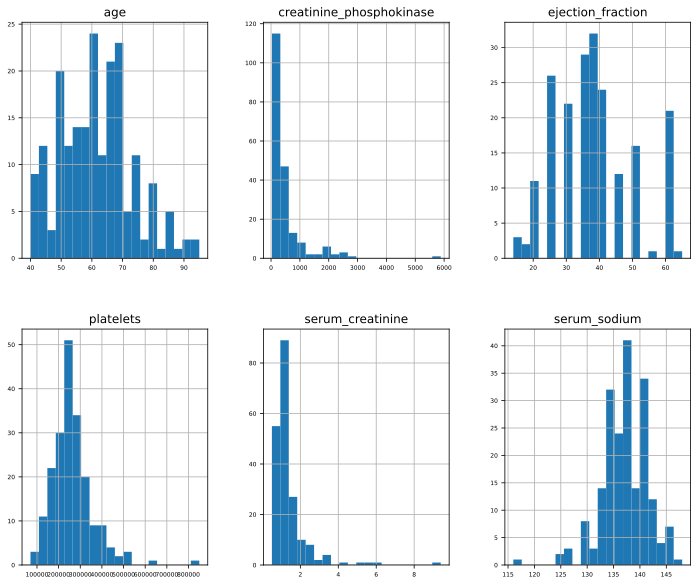

In [8]:
df_num_features = df_train.drop(columns=['anaemia', 'diabetes', 'high_blood_pressure', 
                                         'sex', 'smoking', 'DEATH_EVENT', 'time'])
df_num_features.hist(figsize=(12, 10), bins=20, grid=True, layout=(-1, 3));

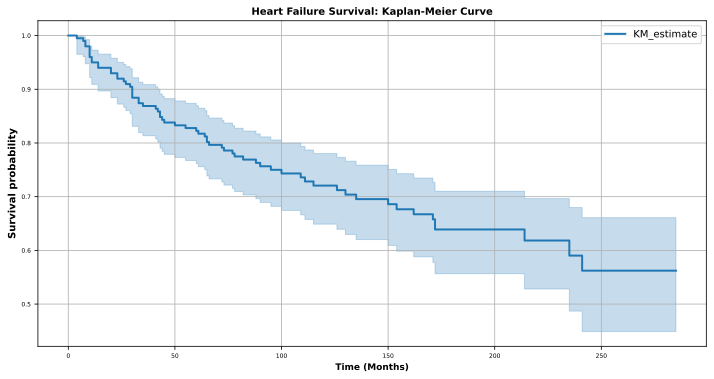

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(df_train['time'], df_train['DEATH_EVENT'])
kmf.plot(linewidth=2, figsize=(12, 6))
plt.title('Heart Failure Survival: Kaplan-Meier Curve', fontsize=10, fontweight='bold')
plt.xlabel('Time (Months)', fontsize=9, fontweight='bold')
plt.ylabel('Survival probability', fontsize=10, fontweight='bold')
plt.grid()

plt.show()

In [10]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
4.0,0.995000
7.0,0.990000
8.0,0.980000
10.0,0.960000
...,...
258.0,0.562166
270.0,0.562166
271.0,0.562166


In [11]:
feature_names = df_train.drop(df_num_features, axis=1)
feature_names_cat = feature_names.drop(['DEATH_EVENT', 'time'], axis=1).columns.tolist()
feature_names_cat

['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

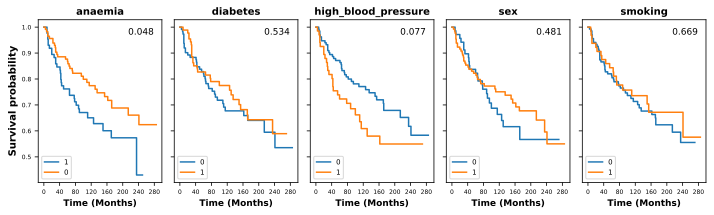

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, 
                         sharex = True, sharey = True,
                         figsize=(12, 3)
                        )
plt.xticks(np.arange(0, 290, 40))

def categorical_km_curves(feature, t='time', event='DEATH_EVENT', df=feature_names, ax=None):
    for cat in (df[feature].unique()):
        idx = df[feature] == cat
        kmf = KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat, ci_show=False)

for cat, ax in zip(feature_names_cat, axes.flatten()):
    categorical_km_curves(feature=cat, t='time', event='DEATH_EVENT', df = feature_names, ax=ax)
    ax.legend(loc='lower left', prop={'size': 7})
    ax.set_title(cat, pad=5, fontsize=10, fontweight='bold')
    p = multivariate_logrank_test(feature_names['time'], feature_names[cat], feature_names['DEATH_EVENT'])
    ax.add_artist(AnchoredText(p.p_value.round(3), frameon=False, 
                               loc='upper right', prop=dict(size=9)))
    ax.set_xlabel('Time (Months)', fontsize = 9, fontweight='bold')
    ax.set_ylabel('Survival probability', fontsize = 10, fontweight='bold')
#     add_at_risk_counts(kmf, ax=ax, fig=fig, labels=[cat])
    
fig.subplots_adjust(wspace = 0.1)

plt.show()

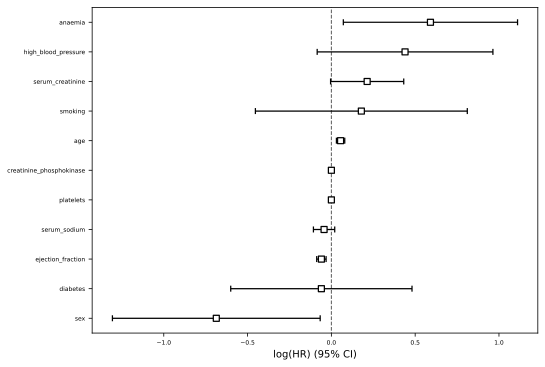

In [13]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col='time', event_col='DEATH_EVENT')

plt.figure(figsize=(8, 6))
cph.plot()
plt.show()

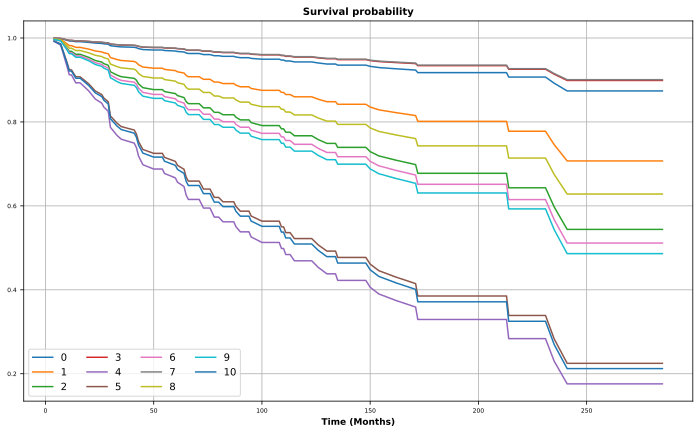

In [14]:
survival_func_plot = cph.predict_survival_function(df_test)

plt.figure(figsize=(12, 7))
plt.plot(survival_func_plot.loc[:, 0:10])
plt.legend(labels=survival_func_plot.loc[:, 0:10].columns, loc ="lower left", ncol=4)

plt.grid()
plt.xlabel('Time (Months)', fontsize=9, fontweight='bold')
plt.title('Survival probability', fontsize=10, fontweight='bold')
plt.show()

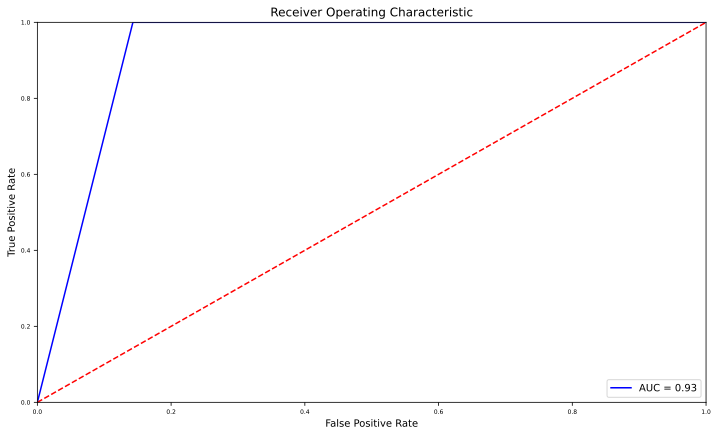

In [15]:
for_prognosis = survival_func_plot.T
estimated_term_in_month = 205

try:
    for_prognosis[estimated_term_in_month]
    for_prognosis = pd.DataFrame(for_prognosis.loc[:][estimated_term_in_month].round(2))
    
    for_prognosis['DEATH_EVENT_PROGNOSIS'] = 0
    for_prognosis.loc[for_prognosis[estimated_term_in_month] < 0.5, 'DEATH_EVENT_PROGNOSIS'] = 1
    preds = pd.DataFrame(for_prognosis['DEATH_EVENT_PROGNOSIS'])

    y_test = pd.DataFrame(df_test[df_test['time'] > estimated_term_in_month]['DEATH_EVENT'])
    
    df_final = y_test.merge(preds, how='outer', left_on=y_test.index, right_on=preds.index)
    df_final = df_final.loc[~df_final['DEATH_EVENT'].isna()]
    
    fpr, tpr, threshold = metrics.roc_curve(df_final['DEATH_EVENT'], df_final["DEATH_EVENT_PROGNOSIS"])
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(12, 7))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
except:
    print('Введите другой период в месяцах')